<a href="https://colab.research.google.com/github/ErickAlcaino/Proyectos/blob/main/Proyectos/SentimientoFrasesConRedes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

# sklearn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split,RepeatedKFold,KFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
def plot_cm(y_pred, y_test, LABELS,titulo ,grados = 0):
  "Función para graficar matriz de confusión"
  ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap=plt.cm.Blues,
      display_labels = LABELS
  )
  plt.xticks(rotation=grados)
  plt.title('Confusion Matrix'+str(titulo))
  plt.show()

def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps


def Validacion_Cruzada(modelos, X_vec, y, paquetes=5):
  for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X_vec, y, cv=paquetes, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    std_accuracy = np.std(scores)

    print(f"Precisión promedio con {nombre}: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

def clean_text(text):
    # Eliminar todo lo que no sea letras, espacios o comas
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Eliminar múltiples espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [3]:
# IMDB estaba solo sacando 748 filas en vez de las 1000, por eso este codigo.
dataimdb = []
with open('/content/drive/My Drive/Data/sentiment labelled sentences/imdb_labelled.txt', 'r', encoding='utf-8') as file:
  for line in file:
    line = line.strip()  # Remove leading/trailing whitespace
    if line:  # Skip empty lines
      try:
        parts = line.split('\t')  # Split by tab delimiter
        if len(parts) == 2:
          dataimdb.append(parts)
        else:
          print(f"Skipping invalid line: {line}")  # Identify problematic lines
      except Exception as e:
        print(f"Error parsing line: {line}, Error: {e}")  # Handle parsing errors

imdb = pd.DataFrame(dataimdb)

print(f"Rows loaded: {len(imdb)}")

Rows loaded: 1000


In [4]:
amazon=pd.read_csv('/content/drive/My Drive/Data/sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)
#imdb=pd.read_csv('/content/drive/My Drive/Data/sentiment labelled sentences/imdb_labelled.txt', delimiter='\t', header=None) #No extrae todas las filas
yelp=pd.read_csv('/content/drive/My Drive/Data/sentiment labelled sentences/yelp_labelled.txt', delimiter='\t', header=None)
texto=pd.concat([amazon,imdb,yelp])
texto.columns=['Frases','Valor']
texto['Valor'] = pd.to_numeric(texto['Valor']).astype(int)
data=texto.copy()

display(datainfo(texto))

#Todas las frases en  minusculaaaa
texto['Frases'] = texto['Frases'].str.lower()
texto['Frases'] = texto['Frases'].str.replace(r'\.', ' ', regex=True)


display(texto[texto['Valor']==1])

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
Frases,object,3000,2983,0,0.0
Valor,int64,3000,2,0,0.0


,Frases,Valor
1,"good case, excellent value",1
2,great for the jawbone,1
4,the mic is great,1
7,if you are razr owner you must have this!,1
10,and the sound quality is great,1
...,...,...
899,"overall, a great experience",1
901,their regular toasted bread was equally satisf...,1
907,the chips and sals a here is amazing!!!!!!!!!!...,1
909,this is my new fav vegas buffet spot,1


In [5]:
texto['Frases'] = texto['Frases'].apply(clean_text)
display(texto[texto['Valor']==1])

,Frases,Valor
1,good case excellent value,1
2,great for the jawbone,1
4,the mic is great,1
7,if you are razr owner you must have this,1
10,and the sound quality is great,1
...,...,...
899,overall a great experience,1
901,their regular toasted bread was equally satisf...,1
907,the chips and sals a here is amazing,1
909,this is my new fav vegas buffet spot,1


In [6]:

X = texto['Frases']
y = texto['Valor']

tfidf_vectorizer = TfidfVectorizer()
X_TF= tfidf_vectorizer.fit_transform(X)

vectorizer = CountVectorizer()
X_BOW = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_BOW, y, test_size=0.1, random_state=42)




In [7]:
model = keras.Sequential([
    keras.layers.Dense(6, activation='relu', input_shape=[X_train.shape[1]]),
    keras.layers.Dropout(0.3),  # Regularización con dropout
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=13,
    callbacks=[early_stopping],
    verbose=1,
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4933 - loss: 0.6933 - val_accuracy: 0.6367 - val_loss: 0.6856
Epoch 2/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6098 - loss: 0.6832 - val_accuracy: 0.6733 - val_loss: 0.6614
Epoch 3/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6682 - loss: 0.6515 - val_accuracy: 0.7200 - val_loss: 0.6178
Epoch 4/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7795 - loss: 0.6013 - val_accuracy: 0.7433 - val_loss: 0.5640
Epoch 5/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8390 - loss: 0.5304 - val_accuracy: 0.7733 - val_loss: 0.5162
Epoch 6/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8809 - loss: 0.4630 - val_accuracy: 0.8067 - val_loss: 0.4756
Epoch 7/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9128 - loss: 0.3985 - val_accuracy: 0.8133 - val_loss: 0.4448
Epoch 8/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9386 - loss: 0.3392 - val_accuracy: 0.8233 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │          31,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,325 (368.46 KB)

 Trainable params: 31,441 (122.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,884 (245.64 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


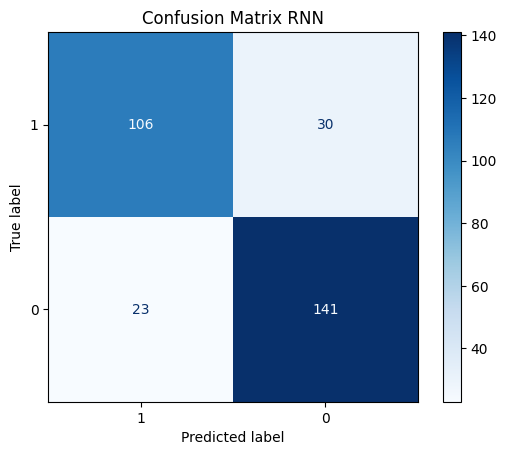

In [8]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
plot_cm(y_pred, y_test, ['1', '0'], ' RNN')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


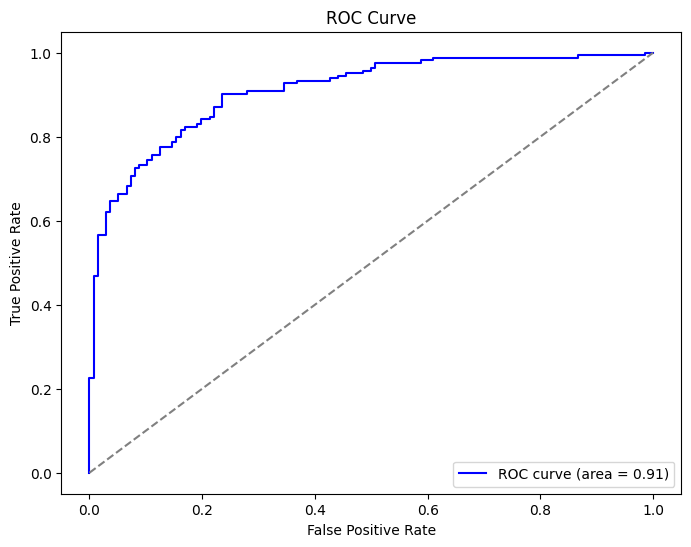

In [9]:
y_pred_proba = model.predict(X_test).ravel()


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()